In [1]:
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import date, datetime, timedelta
from collections import Counter
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
%matplotlib inline

from sklearn import linear_model as lm
from sklearn import ensemble as ens

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import os

In [3]:
os.listdir('data')

['data_with_dummies.csv',
 'data_with_usd.csv',
 'data_with_dummies_and_class.csv',
 'data_nobadrows.csv',
 'all_data.csv',
 'data_with_pos',
 'ks-projects-201801.csv',
 'ks-projects-201612.csv',
 'data_with_pos.csv',
 'exchange.csv']

In [4]:
df = pd.read_csv('data/data_with_dummies_and_class.csv')

In [5]:
keep_cols = [x for x in df.columns if 'Unnamed' not in x]
df = df[keep_cols].set_index('ID')

In [6]:
df.shape

(694192, 250)

In [8]:
features = Counter()
for col in df.columns:
    features[col.split('&')[0].strip()] += 1
features = pd.Series(features)

In [48]:
features

backers                      1
category                   159
country                     22
currency                    14
deadline_month              12
goal                         1
launched_month              12
length                       1
main_category               15
name$adj_count               1
name$caps_count              1
name$determinator_count      1
name$noun_count              1
name$possesive_count         1
name$preposition_count       1
name$punc_count              1
name$verb_count              1
name$word_count              1
pledged                      1
success                      1
usd pledged                  1
usd_pledged_real             1
dtype: int64

In [51]:
dfl = df.drop(['usd pledged', 'pledged', 'usd_pledged_real'], axis=1)

In [52]:
## drop catagory from axis (too many datapoints [159])
df_logis = dfl.drop([col for col in dfl.columns if col.split('&')[0] == 'category'], axis=1)

In [53]:
df_logis = df_logis.dropna()

In [54]:
features = Counter()
for col in df_logis.columns:
    features[col.split('&')[0].strip()] += 1
features = pd.Series(features)
features

backers                     1
country                    22
currency                   14
deadline_month             12
goal                        1
launched_month             12
length                      1
main_category              15
name$adj_count              1
name$caps_count             1
name$determinator_count     1
name$noun_count             1
name$possesive_count        1
name$preposition_count      1
name$punc_count             1
name$verb_count             1
name$word_count             1
success                     1
dtype: int64

In [55]:
## manual model
# model = ens.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# cv = pd.Series(np.random.choice(range(5), df_logis.shape[0]), index=df_logis.index)

# Xtr = df_logis.loc[cv != 0, :]
# Xte = df_logis.loc[cv == 0, :]
# ytr = Xtr.pop('success')
# yte = Xte.pop('success')

# model.fit(Xtr, ytr)

# # float((model.predict(Xte) == yte).sum()) / yte.size

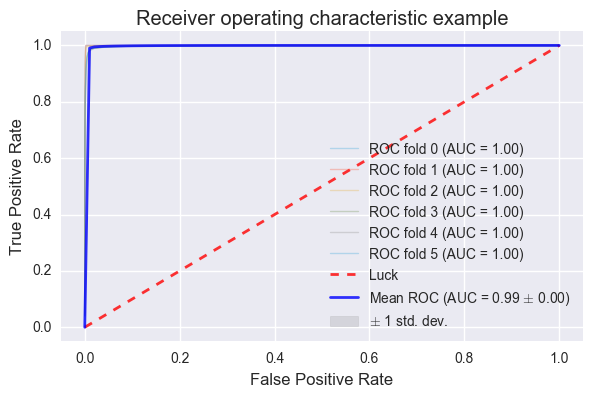

In [56]:
# #############################################################################
# Data IO and generation

# Import some data to play with
X = df_logis.copy()
y = X.pop('success')
n_samples, n_features = X.shape

# # Add noisy features
random_state = np.random.RandomState(42)
# # X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)
classifier = ens.RandomForestClassifier(n_estimators=100, 
                                        n_jobs=-1, 
                                        random_state=random_state) 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probs = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probs[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()